In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sequential_backward_selection import SequentialBackwardSelection

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
 'OD280/OD315 of diluted wines', 'Proline']

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
# This is the true test set. The split inside the sequential backward selection is for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [3]:
nbrs = 5
knn = KNeighborsClassifier(n_neighbors=nbrs)
sbs = SequentialBackwardSelection(model=knn, k_features=1, test_size=0.25)

X_train_relevant = sbs.fit_transform(X=X_train_std, y=y_train)

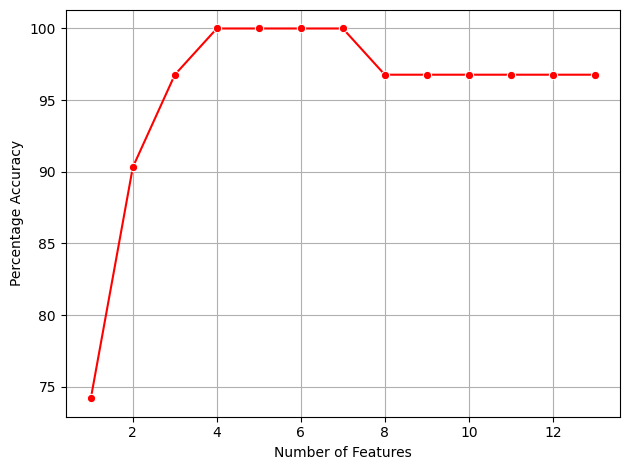

In [4]:
num_features = [len(k) for k in sbs.subsets_]

sns.lineplot(x=num_features, y=np.array(sbs.scores_)*100, marker='o', color='red')
plt.xlabel('Number of Features')
plt.ylabel('Percentage Accuracy')
plt.grid()
plt.tight_layout()
plt.show()

In [5]:
# Curse of dimensionality kicks in after n = 7 best features
# Now which 4 do so well at predicting this (getting 100%)?

max_features = 13
num_features_desired = 4
print(df_wine.columns[1:][sbs.subsets_[max_features - num_features_desired]].values)

best_desired = sbs.subsets_[max_features - num_features_desired]

['Alcohol' 'Alcalinity of ash' 'Total phenols'
 'OD280/OD315 of diluted wines']


In [6]:
# On the original dataset with all features
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.9838709677419355
Test accuracy: 0.9444444444444444


In [7]:
knn.fit(X_train_std[:, best_desired], y_train)
print('Training accuracy:', knn.score(X_train_std[:, best_desired], y_train))
print('Test accuracy:', knn.score(X_test_std[:, best_desired], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.8703703703703703


In [22]:
# This has also been implemented in sklearn
from sklearn.feature_selection import SequentialFeatureSelector
# This can do a forward selection or a backward selection (add features or subtract them in a greedy way)
# The selection criteria is a cross validator (default is 5-fold)

knn = KNeighborsClassifier(n_neighbors=5)
sfs_back = SequentialFeatureSelector(knn, direction='backward', cv=4, n_features_to_select=1)
sfs_forward = SequentialFeatureSelector(knn, direction='forward', cv=4, n_features_to_select=12)

sfs_back.fit(X_train_std, y=y_train)
sfs_forward.fit(X_train_std, y_train)

X_rel = sfs_back.transform(X_train_std)

knn.fit(X_rel, y_train)
print(f"Training score: {knn.score(sfs_back.transform(X_train_std), y_train) * 100:.2f}%.")
print(f"Test score: {knn.score(sfs_back.transform(X_test_std), y_test) * 100:.2f}%.")

Training score: 79.84%.
Test score: 68.52%.


In [27]:
# An easier way to do this: use a tolerance for the amount that this is changing
knn = KNeighborsClassifier(n_neighbors=5)
sfs_back = SequentialFeatureSelector(knn, direction='backward', cv=4, n_features_to_select='auto', tol=0.1)
sfs_back.fit(X_train_std, y=y_train)

X_rel = sfs_back.transform(X_train_std)
print(X_rel.shape[1])

knn.fit(X_rel, y_train)
print(f"Training score: {knn.score(sfs_back.transform(X_train_std), y_train) * 100:.2f}%.")
print(f"Test score: {knn.score(sfs_back.transform(X_test_std), y_test) * 100:.2f}%.")

12
Training score: 97.58%.
Test score: 94.44%.
